<img src="Data/logo_lapage_small.png" />

# <u> Etude des corrélations</u>

# Sommaire

* [Importation des librairies et des fichiers](#chapter1)
* [Modification du Dataframe](#chapter2)
* [Analyse sur le montant du panier](#chapter3)
* [Etude des corrélations](#chapter4)
    * [Genre et catégorie](#section4_1)
    * [Corrélation entre Age et](#section4_2)
        * [Montant total des achats](#section4_2_1)
        * [Montant moyen du panier](#section4_2_2)
        * [Fréquence d'achats](#section4_2_3)
        * [Catégorie de livres](#section4_2_4)     
    * [Autres corrélations](#section4_3)
        * [Montant moyen du panier en fct du genre](#section4_3_1)
        * [Age moyen des acheteurs par produits](#section4_3_2)
    * [Récapitulatif](#section4_4)

# Importation des librairies et des fichiers <a class="anchor" id="chapter1"></a>

Pour cette étude, nous allons utiliser les librairies Pandas pour la gestion des dataframes, Matplotlib et Seaborn pour la création de graphes, Numpy pour les calculs et Scipy pour les statistiques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats as st
import pingouin as pg
# désactivation des messages d'avertissement
from warnings import filterwarnings
filterwarnings('ignore')

Nous importons aussi le fichier créer dans la partie préparatoire.

In [2]:
lapage_df = pd.read_csv("Data/lapage_df.csv")
# changement de types
lapage_df.date = pd.to_datetime(lapage_df.date)
lapage_df.categ = lapage_df.categ.astype(str)

***
***

# Modification du Dataframe <a class="anchor" id="chapter2"></a>
Pour la suite de l'étude, nous excluons les 4 clients BtoB :

In [3]:
# liste des clients BtoB
liste = {"c_4958", "c_3454", "c_6714", "c_1609"}
lapage_df = lapage_df[~lapage_df.client_id.isin(liste)]

***
***

# Analyse sur le montant du panier <a class="anchor" id="chapter3"></a>
Pour celà, nous allons grouper nos données par identifiant de session, par âge et par sexe (en vue d'une étude de l'influence du genre sur le montant des achats).

In [4]:
# création du df
montant_panier_df = pd.DataFrame(lapage_df.groupby(["session_id", "age", "sex"], as_index=False)["price"].sum())
# changement de nom pour la colonne price
montant_panier_df.rename(columns={"price":"montant du panier"}, inplace=True)
# tri par ordre croissant
montant_panier_df.sort_values("montant du panier")

,session_id,age,sex,montant du panier
5919,s_107417,64,f,0.62
162060,s_260416,64,f,0.62
248063,s_34456,82,f,0.62
3710,s_104606,39,m,0.62
258715,s_41352,64,f,0.62
...,...,...,...,...
49556,s_150439,30,m,496.22
238299,s_335005,19,f,535.17
302148,s_83158,19,f,535.17
21350,s_123227,30,f,539.23


Nous pouvons calculer le nombre optimal de tranches pour notre représentation graphique grâce à la règle de Sturges :

In [5]:
# calcul du nb optimal de tranches 
N = len(montant_panier_df) # taille de l'échantillon
# règle de Sturges : k = 1 + log2(N) 
k = 1 + np.log2(N)
print("Le nombre de tranches donné par la règle de Sturges est ici de", round(k))

Le nombre de tranches donné par la règle de Sturges est ici de 19


Le panier moyen est de  34.38 €


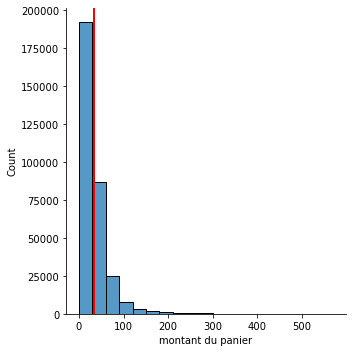

In [6]:
# calcul de la moyenne
panier_moy = montant_panier_df["montant du panier"].mean()

# visualisation
sns.displot(montant_panier_df, x="montant du panier", bins=19)
plt.axvline(x=panier_moy, color='r', linewidth=2, label="panier moyen");
print("Le panier moyen est de ", round(panier_moy,2), "€")

In [7]:
# coefficient d'asymétrie
sk = montant_panier_df["montant du panier"].skew() # 0 pour loi normale
print("Le coefficient d'asymétrie pour la variable 'montant du panier' est de", round(sk,2))
# coefficient d'aplatissement de la courbe
kur = montant_panier_df["montant du panier"].kurtosis()
print("Le coefficient d'aplatissement est de", round(kur,2))

Le coefficient d'asymétrie pour la variable 'montant du panier' est de 3.35
Le coefficient d'aplatissement est de 18.42


La courbe a une distribution unimodale asymétrique vers la droite et est très peu aplatie (en comparaison à la loi Normale). Nous aurions pu vérifier cela avec un test de normalité :

In [8]:
# test de normalité de la librairie Pingouin
pg.normality(montant_panier_df["montant du panier"])

,W,pval,normal
montant du panier,0.711767,0.0,False


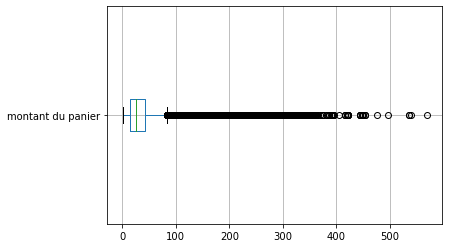

In [9]:
# dispersion de la variable "montant du panier"
plt.figure(figsize=(20,7))
sns.boxplot(x=montant_panier_df["montant du panier"], showmeans=True);

Nous observons beaucoup d'outliers dûs à des sessions d'achat contenant des livres de catégorie 2 (étudiants achetant leurs livres de cours).

In [10]:
print("Nous avons noté", len(montant_panier_df.loc[(montant_panier_df["montant du panier"]>83) & (montant_panier_df.age<=31)]), "sessions de plus de 83€ faites par des personnes de moins de 31 ans")

Nous avons noté 11649 sessions de plus de 83€ faites par des personnes de moins de 31 ans


***
***

# Etude des corrélations <a class="anchor" id="chapter4"></a>
## Genre & Catégorie <a class="anchor" id="section4_1"></a>

Nous pouvons visualiser les 2 variables qualitatives grâce à un diagramme à barres :

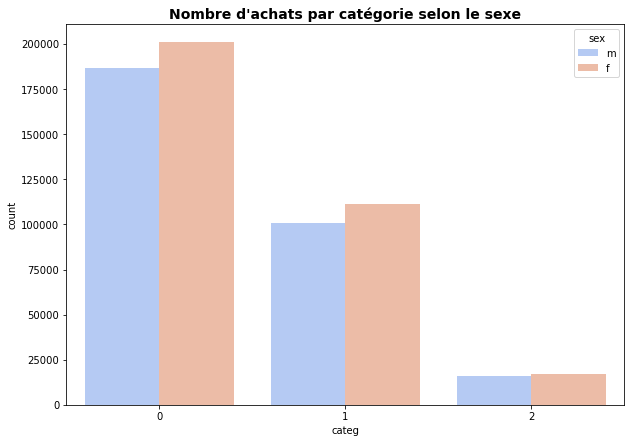

In [11]:
plt.figure(figsize=(10,7))
sns.countplot(x="categ", hue='sex', data =lapage_df, palette='coolwarm')
plt.title("Nombre d'achats par catégorie selon le sexe", fontsize=14, fontweight='bold');

Pour chaque catégorie, il semble y avoir un nombre de ventes équivalent pour les 2 sexes.
>H0 : les 2 variables sont indépendantes <br> H1 : les 2 variables sont corrélées

Nous pouvons tester ces hypothèses avec un test du Khi²:

In [12]:
# tableau de contingence
cont = lapage_df.pivot_table(index="sex", columns="categ", values="id_prod", aggfunc="count", margins=True, margins_name="Total")

# donne dans l'ordre : valeurs du khi2, de la p-value, du nb de degrés de liberté et du tableau de valeurs attendues
khi2, pval, ddl, expected = st.chi2_contingency(cont, correction=True)
# résultat du test du khi2
if pval>0.05:
    print("La p-value est de ", round(pval,3), ", l'hypothèse nulle est retenue, les 2 variables sont indépendantes au seuil de 5%.")
else:
    print("La p-value est de ", round(pval,3), ", l'hypothèse nulle est rejetée, les 2 variables sont corrélées.")

La p-value est de  0.003 , l'hypothèse nulle est rejetée, les 2 variables sont corrélées.


Les nombres de ventes ne peuvent significativement pas être considérées comme égaux, il y a bien une différence d'achats selon le genre du client.

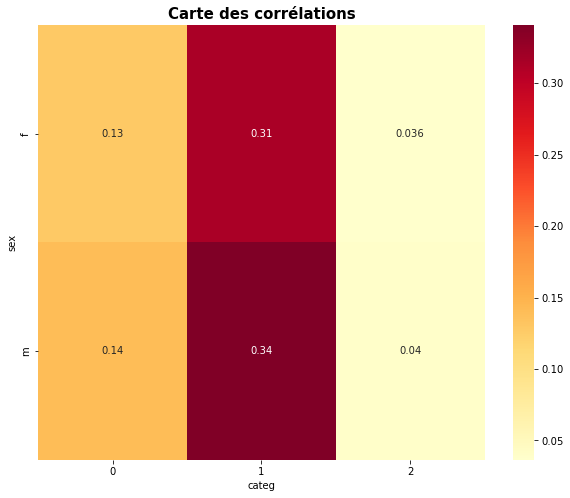

In [13]:
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(lapage_df)
indep = tx.dot(ty) / n

# matrice des écarts au carré normalisés
measure = (cont-indep)**2/indep #formule générale du khi²
table = measure/khi2

# visualisation
plt.figure(figsize=(10,8))
sns.heatmap(table.iloc[:-1,:-1], annot=table.iloc[:-1,:-1], cmap =("YlOrRd"))
plt.title("Carte des corrélations", fontsize=15, fontweight='bold')
plt.show()

Les écarts entre les valeurs théoriques et les valeurs observées sont les plus forts pour la catégorie 1 ce qui confirme la dépendance des 2 variables.

***

## Corrélation entre Age et ... <a class="anchor" id="section4_2"></a>
### Montant total des achats (CA) <a class="anchor" id="section4_2_1"></a>
Nous regroupons les informations selon l'age des clients : montant total des achats, moyenne mobile associée, nombre de clients par classe d'age et montant moyen des achats

In [14]:
# création du df, infos regroupées par age
age_montant_df = lapage_df.groupby("age", as_index=False).agg({"price":"sum", "client_id":"nunique"})
# colonne en moyenne mobile, permet de lisser les résultats
age_montant_df["total des achats (moyenne mobile)"] = age_montant_df.price.rolling(5, center=True).mean()
# colonne de la moyenne des dépenses par âge
age_montant_df["montant total moyen"] = age_montant_df.price / age_montant_df.client_id
# renommage de colonnes pour plus de clarté
age_montant_df.rename(columns={"price":"total des achats", "client_id":"nombre de clients"}, inplace=True)

Nous recherchons ici la corrélation entre 2 variables quantitatives. Testons tout d'abord la normalité de ces variables :

In [15]:
print(pg.normality(age_montant_df["total des achats"]))
print(pg.normality(age_montant_df["age"]))

                         W      pval  normal
total des achats  0.911737  0.000061   False
            W      pval  normal
age  0.954924  0.008754   False


Les 2 variables ne suivent pas de loi normale. Les tests statistiques seront donc non-paramétriques.<br>

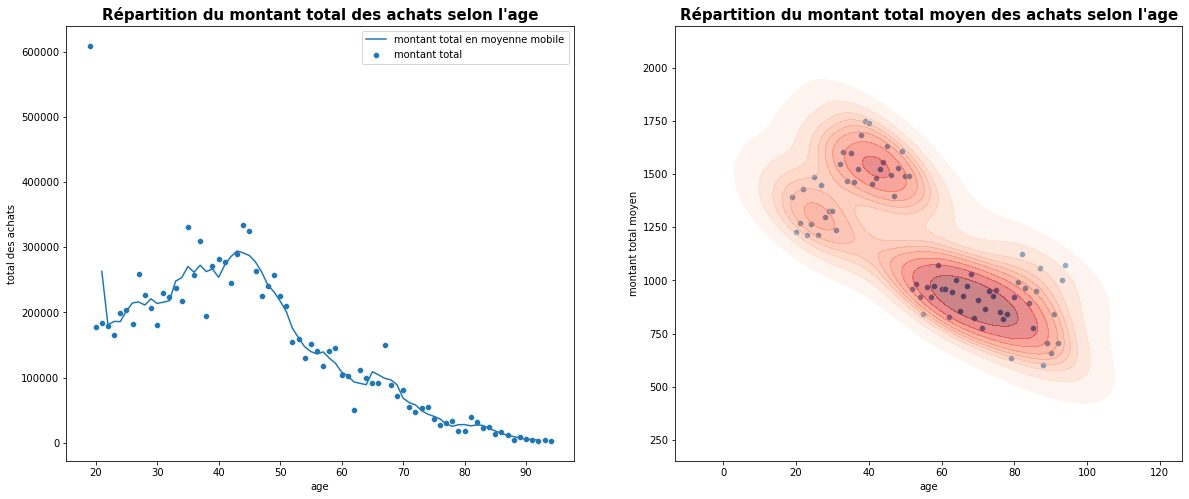

In [16]:
# visualisation
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.scatterplot("age", "total des achats", data=age_montant_df, label="montant total")
plt.plot("age", "total des achats (moyenne mobile)", data=age_montant_df, label="montant total en moyenne mobile")
plt.title("Répartition du montant total des achats selon l'age", fontsize=15, fontweight='bold')
plt.legend()
plt.subplot(1,2,2)
sns.scatterplot(x="age", y="montant total moyen", data=age_montant_df)
sns.kdeplot(x="age", y="montant total moyen", cmap= "Reds", shade=True, alpha=0.5, data=age_montant_df)
plt.title("Répartition du montant total moyen des achats selon l'age", fontsize=15, fontweight='bold');

NB : les clients de 19 ans et certains de 20 ans n'auraient pas pu pouvoir acheter au début de l'étude, <code>lapage_df.loc[lapage_df.age == 19].sort_values("date")</code> montre le contraire.<br>

Le nuage de points montre que la relation n'est ni linéaire, ni monotone, nous utiliserons donc un test de corrélation de Kendall
> H0 : il n'y a pas de corrélation entre le montant total des achats et l'âge<br>  H1 : les 2 variables sont corrélées.<br>

In [17]:
corr, pval = st.kendalltau(age_montant_df["age"], age_montant_df["total des achats"])
if pval>0.05:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est retenue, les 2 variables sont indépendantes au seuil de 5%.")
else:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est rejetée, les 2 variables sont corrélées.")
    print("le τ de Kendall est de", round(corr,3))

La p-value est de 0.0 , l'hypothèse nulle est rejetée, les 2 variables sont corrélées.
le τ de Kendall est de -0.708


Le second graphique montre l'existence de 3 sous-groupes : les 19-31 ans ("les étudiants"), les 32-51 ans ("les actifs") et les 52 ans et + ("les seniors"). Des études selon ces groupes sont à envisager pour des appréciations plus fines de leurs habitudes d'achat.

#### <u>Etude par Tranche d'âge</u>

Nous regroupons nos valeurs selon nos 3 populations

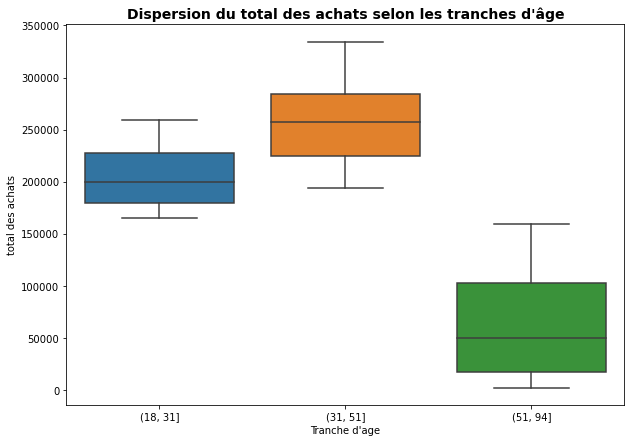

In [18]:
age_montant_df["Tranche d'age"] = pd.cut(age_montant_df.age, bins=[18,31,51,94]) 

# visualisation
plt.figure(figsize=(10,7))
sns.boxplot(x="Tranche d'age", y="total des achats", data=age_montant_df, showfliers=False)
plt.title("Dispersion du total des achats selon les tranches d'âge", fontsize=14, fontweight='bold')
plt.show();

Les distributions n'étant pas normales, le test ANOVA sera remplacé par son équivalent non-paramétrique pour plusieurs groupes, <i>i.e.</i> le test de Kruskal-Wallis.
> H0 : il y a égalité des médianes<br> H1 : les médianes sont différentes

In [19]:
# array des tranches d'age
tranches_d_age = age_montant_df["Tranche d'age"].unique()
# test de Kruskal-Wallis
corr, pval = st.kruskal(age_montant_df[age_montant_df["Tranche d'age"] == tranches_d_age[0]]["total des achats"],
                        age_montant_df[age_montant_df["Tranche d'age"] == tranches_d_age[1]]["total des achats"],
                        age_montant_df[age_montant_df["Tranche d'age"] == tranches_d_age[2]]["total des achats"])
if pval>0.05:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est retenue, les 3 échantillons sont issus de la même population.")
else:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est rejetée, les 3 échantillons sont différents.")
    print("La sτatistique de Kruskal-Wallis est de", round(corr,3))

La p-value est de 0.0 , l'hypothèse nulle est rejetée, les 3 échantillons sont différents.
La sτatistique de Kruskal-Wallis est de 57.122


### Montant moyen du panier en fonction de l'age <a class="anchor" id="section4_2_2"></a>

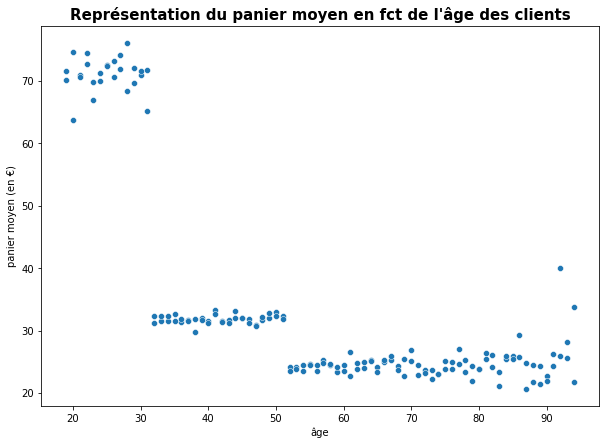

In [20]:
# calcul du montant moyen du panier en fct de l'age
panier_moyen_df = montant_panier_df.groupby(["age", "sex"], as_index=False)["montant du panier"].mean()

#visualisation
plt.figure(figsize=(10,7))
sns.scatterplot(x="age", y="montant du panier", data=panier_moyen_df)
plt.title("Représentation du panier moyen en fct de l'âge des clients", fontsize=15, fontweight='bold')
plt.xlabel("âge")
plt.ylabel("panier moyen (en €)")
plt.show();

Normalité de nos variables :

In [21]:
print(pg.normality(panier_moyen_df["age"]))
print(pg.normality(panier_moyen_df["montant du panier"]))

            W      pval  normal
age  0.954261  0.000067   False
                          W          pval  normal
montant du panier  0.645238  1.271780e-17   False


Les 2 variables ne suivent pas une distribution normale. Le nuage de points montre une relation monotone (décroissante), nos hypothèses seront soumises à un test de Spearman :

>H0 : pas de corrélation entre le montant du panier moyen et l'âge des clients<br>
H1 : il existe une corrélation<br>

In [22]:
pg.corr(panier_moyen_df.age, panier_moyen_df["montant du panier"], method='spearman')

,n,r,CI95%,p-val,power
spearman,152,-0.740745,"[-0.81, -0.66]",1.061395e-27,1.0


p < 0.05, rejet de H0, il existe une corrélation négative forte et statistiquement significative.

#### <u>Etude par Tranche d'âge</u>

Nous regroupons nos valeurs selon nos 3 populations

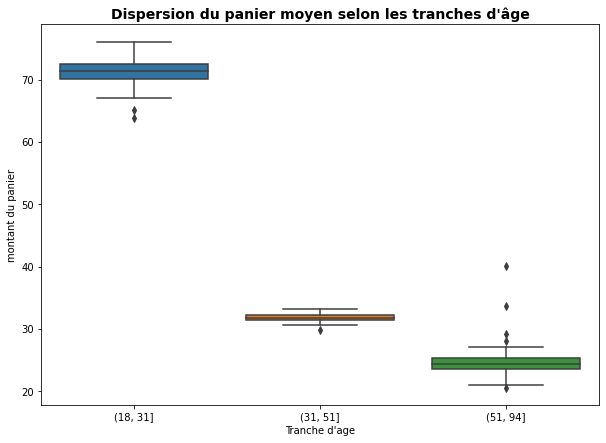

In [23]:
# ajout de la colonne "Tranche d'age" 
panier_moyen_df["Tranche d'age"] = pd.cut(panier_moyen_df.age, bins=[18,31,51,94])

# visualisation
plt.figure(figsize=(10,7))
sns.boxplot(x="Tranche d'age", y="montant du panier", data=panier_moyen_df)
plt.title("Dispersion du panier moyen selon les tranches d'âge", fontsize=14, fontweight='bold')
plt.show();

Les distributions n'étant pas normales, le test ANOVA sera remplacé par son équivalent non-paramétrique pour plusieurs groupes, <i>i.e.</i> le test de Kruskal-Wallis.
> H0 : il y a égalité des médianes<br> H1 : les médianes sont différentes

In [24]:
# array des tranches d'age
tranches_d_age = panier_moyen_df["Tranche d\'age"].unique()
# test de Kruskal-Wallis
corr, pval = st.kruskal(panier_moyen_df[panier_moyen_df["Tranche d'age"] == tranches_d_age[0]]["montant du panier"],
                        panier_moyen_df[panier_moyen_df["Tranche d'age"] == tranches_d_age[1]]["montant du panier"],
                        panier_moyen_df[panier_moyen_df["Tranche d'age"] == tranches_d_age[2]]["montant du panier"])
if pval>0.05:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est retenue, les 3 échantillons sont issus de la même population.")
else:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est rejetée, les 3 échantillons sont différents.")
    print("le sτatistique de Kruskal-Wallis est de", round(corr,3))

La p-value est de 0.0 , l'hypothèse nulle est rejetée, les 3 échantillons sont différents.
le sτatistique de Kruskal-Wallis est de 115.068


### Fréquence d'achats <a class="anchor" id="section4_2_3"></a>
La fréquence d'achats mensuelle se calcule en comptant le nombre de sessions par client divisée par le temps d'étude (24 mois) :

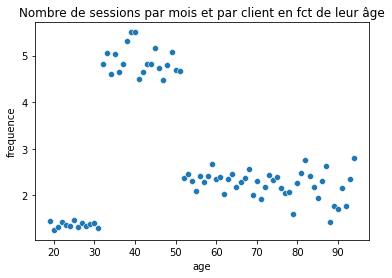

In [25]:
# création du df et calcul de la fréquence
frequence_achats_df = lapage_df.groupby("age", as_index=False).agg({"session_id":"count", "client_id":pd.Series.nunique})
frequence_achats_df["frequence"] = frequence_achats_df["session_id"] / frequence_achats_df["client_id"] / 24

# visualisation
plt.figure(figsize=(10,7))
sns.scatterplot(x="age", y="frequence", data=frequence_achats_df)
plt.title("Nombre de sessions par mois et par client en fct de leur âge", fontsize=14, fontweight='bold');

In [26]:
pg.normality(frequence_achats_df.frequence)

,W,pval,normal
frequence,0.820888,3.520476e-08,False


In [27]:
pg.normality(frequence_achats_df.age)

,W,pval,normal
age,0.954924,0.008754,False


Nos 2 variables ne suivent pas une loi normale. Le nuage de points montre que la relation n'est ni linéaire, ni monotone, nous utiliserons donc un test de corrélation de Kendall
> H0 : il n'y a pas de corrélation entre la fréquence des sessions et l'âge<br>  H1 : les 2 variables sont corrélées.<br>

In [28]:
corr, pval = st.kendalltau(frequence_achats_df.age, frequence_achats_df.frequence)
if pval>0.05:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est retenue, les 2 variables sont indépendantes au seuil de 5%.")
else:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est rejetée, les 2 variables sont corrélées.")
    print("le τ de Kendall est de", round(corr,3))

La p-value est de 0.286 , l'hypothèse nulle est retenue, les 2 variables sont indépendantes au seuil de 5%.


#### Etude par Tranche d'âge

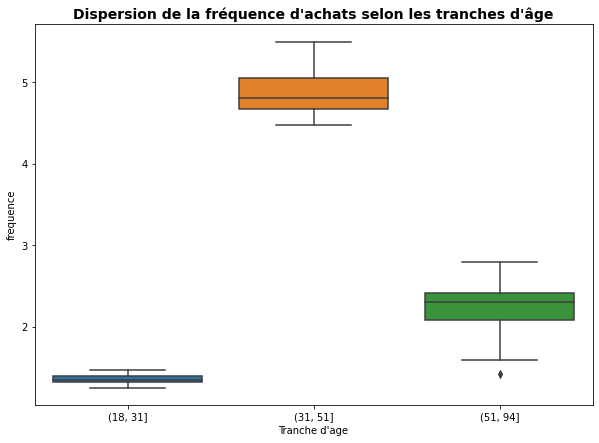

In [29]:
frequence_achats_df["Tranche d'age"] = pd.cut(frequence_achats_df.age, bins=[18,31,51,94])

# visualisation
plt.figure(figsize=(10,7))
sns.boxplot(x="Tranche d'age", y="frequence", data=frequence_achats_df)
plt.title("Dispersion de la fréquence d'achats selon les tranches d'âge", fontsize=14, fontweight='bold')
plt.show();

Les distributions ne suivent pas la loi normale, le test ANOVA sera remplacé par son équivalent non-paramétrique pour plusieurs groupes, <i>i.e.</i> le test de Kruskal-Wallis.
> H0 : il y a égalité des médianes<br> H1 : les médianes sont différentes

In [30]:
# array des tranches d'age
tranches_d_age = frequence_achats_df["Tranche d'age"].unique()
# test de Kruskal-Wallis
corr, pval = st.kruskal(frequence_achats_df[frequence_achats_df["Tranche d'age"] == tranches_d_age[0]]["frequence"],
                        frequence_achats_df[frequence_achats_df["Tranche d'age"] == tranches_d_age[1]]["frequence"],
                        frequence_achats_df[frequence_achats_df["Tranche d'age"] == tranches_d_age[2]]["frequence"])
if pval>0.05:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est retenue, les 3 échantillons sont issus de la même population.")
else:
    print("La p-value est de", round(pval,3), ", l'hypothèse nulle est rejetée, les 3 échantillons sont différents.")
    print("le sτatistique de Kruskal-Wallis est de", round(corr,3))

La p-value est de 0.0 , l'hypothèse nulle est rejetée, les 3 échantillons sont différents.
le sτatistique de Kruskal-Wallis est de 59.342


***

### Catégorie de livres <a class="anchor" id="section4_2_4"></a>

Nous étudions ici une variable quantitative et une variable qualitative

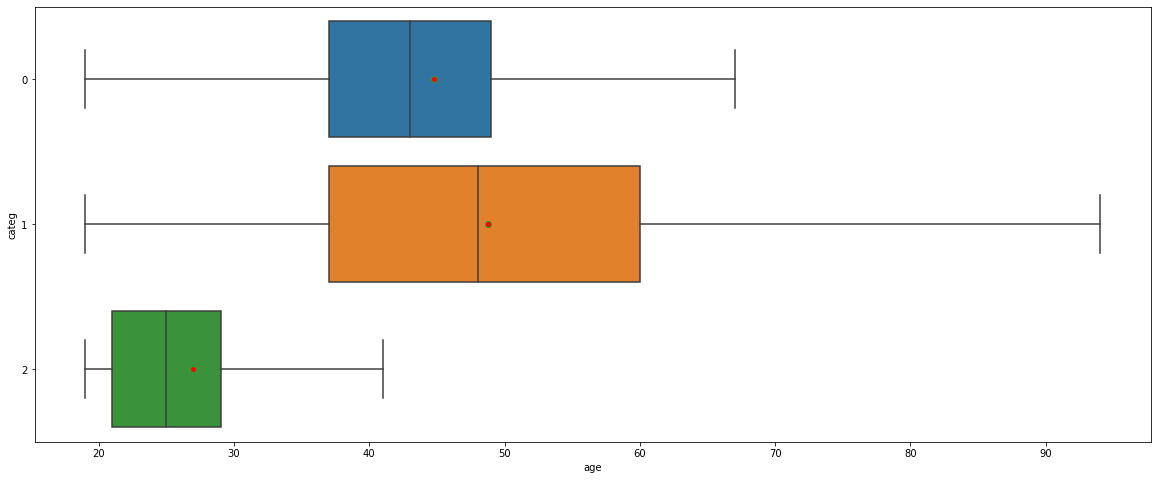

In [32]:
plt.figure(figsize=(20,8))
sns.boxplot(x="age", y="categ", data=lapage_df, orient="h", fliersize=0, showmeans=True, meanprops = {'marker':'o', 'markerfacecolor':'red'});

<AxesSubplot:xlabel="Tranche d'age">

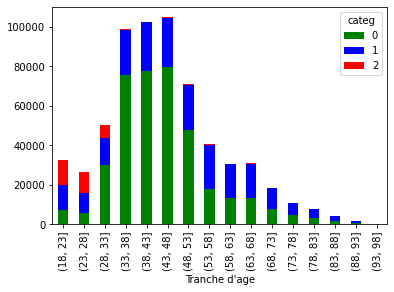

In [33]:
cat_age_df = pd.crosstab(lapage_df["Tranche d'age"], lapage_df.categ)
cat_age_df.plot.bar(stacked=True, color={"#3274a1", "#e1812c", "#3a923a"})

In [34]:
khi2, pval, ddl, expected = st.chi2_contingency(cat_age_df, correction=True)

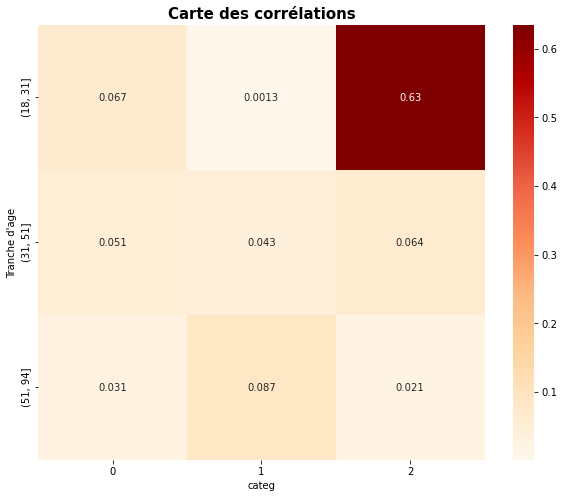

In [36]:
# variables étudiées
X = "Tranche d'age"
Y = "categ"

# tableau de contingence
cont = lapage_df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

# total par X
tx = cont.loc[:,["Total"]]
# total par Y
ty = cont.loc[["Total"],:]
n = len(lapage_df)
indep = tx.dot(ty) / n

measure = (cont-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

# visualisation
plt.figure(figsize=(10,8))
sns.heatmap(table.iloc[:-1,:-1],cmap=("OrRd"),annot=table.iloc[:-1,:-1])
plt.title("Carte des corrélations", fontsize=15, fontweight='bold')
plt.show()

Nous avons confirmation de la non indépendance de nos variables : les écarts entre valeurs théoriques et valeurs observées sont très important pour la catégorie 2 dans la tranche des 19-31 ans.

***
***

## Autres corrélations <a class="anchor" id="section4_3"></a>
### Montant moyen du panier en fct du sexe <a class="anchor" id="section4_3_1"></a>

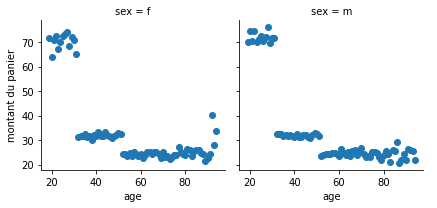

In [37]:
sns.FacetGrid(panier_moyen_df, col="sex").map(plt.scatter, "age", "montant du panier").add_legend();

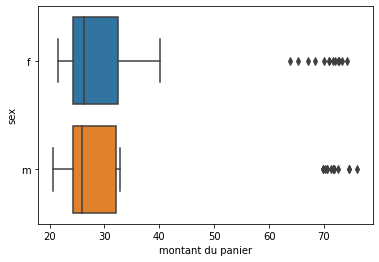

In [38]:
sns.boxplot(y="sex", x="montant du panier", data=panier_moyen_df, orient="h");

In [39]:
# test de normalités pour les 2 genres
print(pg.normality(panier_moyen_df[panier_moyen_df.sex == 'f']["montant du panier"]))
print(pg.normality(panier_moyen_df[panier_moyen_df.sex == 'm']["montant du panier"]))

                          W          pval  normal
montant du panier  0.652508  4.014176e-12   False
                          W          pval  normal
montant du panier  0.636064  1.973604e-12   False


Les 2 populations ne suivent pas une loi normale, nous effectuons donc un test non-paramétrique pour savoir si elles sont identiques<br>
>H0 : Nos 2 distributions sont identiques<br>H1 : Elles sont différentes<br>

In [40]:
stat, pval = st.mannwhitneyu(panier_moyen_df[panier_moyen_df.sex == 'f']["montant du panier"], panier_moyen_df[panier_moyen_df.sex == 'm']["montant du panier"])
if pval>0.05:
    print("La p_value est de ",pval, ", l'hypothèse nulle est retenue, les 2 échantillons ont la même distribution au seuil de 5%.")
else:
    print("La p_value est de ",pval, ", l'hypothèse nulle est rejetée, les 2 échantillons n'ont pas la même distribution.")

La p_value est de  0.8842723550299203 , l'hypothèse nulle est retenue, les 2 échantillons ont la même distribution au seuil de 5%.


Nos 2 distributions sont statistiquement identiques.

### Age moyen des acheteurs par produit <a class="anchor" id="section4_3_2"></a>

Nous pouvons créer un dataframe sur l'age moyen des clients par produit et ensuite le joindre au dataframe de nos ventes par produit:

In [42]:
top_df = pd.read_csv('Data/top_df.csv')
# age moyen par produit
age_prod_df = lapage_df.groupby("id_prod", as_index=False)["age"].mean()
top_age_df = pd.merge(top_df, age_prod_df, on="id_prod", how="inner")
top_age_df

,id_prod,nombre de ventes,age
0,1_369,2252,49.531855
1,1_417,2189,48.283691
2,1_414,2180,49.479004
3,1_498,2128,48.394617
4,1_425,2096,49.296787
...,...,...,...
3258,0_1539,1,35.000000
3259,0_1151,1,50.000000
3260,0_549,1,36.000000
3261,2_98,1,20.000000


In [43]:
top_age_df.age.describe()

count    3263.000000
mean       44.328667
std         6.620058
min        19.000000
25%        42.797338
50%        44.983073
75%        47.774194
max        78.000000
Name: age, dtype: float64

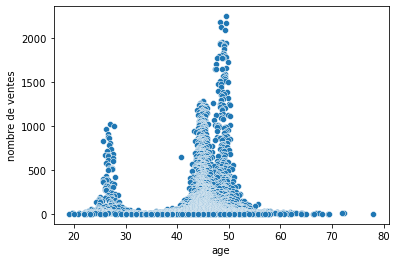

In [44]:
sns.scatterplot(x='age', y='nombre de ventes', data=top_age_df);

Piste d'étude : age des acheteurs par produit

***
***

# Récapitulatif <a class="anchor" id="section4_4"></a>

99.7% de nos clients ont commandé en ligne au cours des 2 dernières années.<br>L'âge moyen de nos clients est de 44.7 ans.<br>Il y a statistiquement autant de clients femmes que de clients hommes avec une distribution en âge identiques.<br>Les femmes représentent 52% de notre clientèle.